In [93]:
import os, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
from scipy.stats import norm, qmc  # for LHS/Sobol candidate sampling
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed




In [94]:

# === PATHS ===
BASE_DIR = r"C:/Users/User/OneDrive - Aaryaa Technologies Limited (1)/Document/Imperial_IIT_Local/data/initial_data"
WEEKLY_DIR = r"C:/Users/User/OneDrive - Aaryaa Technologies Limited (1)/Document/Imperial_IIT_Local/data/weekly_data"

# === LOAD INITIAL DATA ===
function_dirs = sorted(
    [os.path.join(BASE_DIR, d) for d in os.listdir(BASE_DIR) if d.startswith("function_")]
)

functions_data = {}

for folder in function_dirs:
    func_name = os.path.basename(folder)
    x_path = os.path.join(folder, "initial_inputs.npy")
    y_path = os.path.join(folder, "initial_outputs.npy")
    
    if os.path.exists(x_path) and os.path.exists(y_path):
        X = np.load(x_path)
        y = np.load(y_path)
        functions_data[func_name] = {"X": X, "y": y}
        print(f"Loaded {func_name}: X{X.shape}, y{y.shape}")
    else:
        print(f" Missing files in {func_name}")

print("\n All initial data loaded successfully!")

# === APPEND WEEKLY DATA ===
if os.path.exists(WEEKLY_DIR):
    weekly_files = sorted([f for f in os.listdir(WEEKLY_DIR) if f.endswith(".csv")])

    for wk_file in weekly_files:
        print(f"\n Processing weekly file: {wk_file}")
        df = pd.read_csv(os.path.join(WEEKLY_DIR, wk_file))
        df.columns = df.columns.str.strip().str.lower()

        func_col = [c for c in df.columns if "function" in c]
        y_col = [c for c in df.columns if c in ("y", "output", "value")]

        if not func_col or not y_col:
            print(f" Unexpected column names in {wk_file}: {df.columns.tolist()}")
            continue

        func_col, y_col = func_col[0], y_col[0]

        for _, row in df.iterrows():
            func = str(row[func_col]).strip()
            if func in functions_data:
                try:
                    # Handle case where inputs are stored as a stringified list
                    if "x" in df.columns:
                        X_new = np.array(ast.literal_eval(row["x"]), dtype=float).reshape(1, -1)
                    else:
                        x_cols = [c for c in df.columns if c.startswith("x_")]
                        X_new = row[x_cols].values.astype(float).reshape(1, -1)

                    y_new = np.array([float(row[y_col])], dtype=float)

                    X_old, y_old = functions_data[func]["X"], functions_data[func]["y"]

                    if X_new.shape[1] != X_old.shape[1]:
                        print(f" Dim mismatch for {func}: expected {X_old.shape[1]}, got {X_new.shape[1]}")
                        continue

                    functions_data[func]["X"] = np.vstack([X_old, X_new])
                    functions_data[func]["y"] = np.concatenate([y_old, y_new])

                    #  Fixed f-string
                    print(f" Added {func}: now X{functions_data[func]['X'].shape}, y{functions_data[func]['y'].shape}")
                except Exception as e:
                    print(f" Could not parse row for {func}: {e}")
                    continue
            else:
                print(f" Function {func} not found in initial data.")
else:
    print(" No weekly_data directory found.")

print("\n All current data loaded and updated successfully!")

# Access data for functions
X1 = functions_data["function_1"]["X"]
y1 = functions_data["function_1"]["y"]
X2 = functions_data["function_2"]["X"]
y2 = functions_data["function_2"]["y"]
X3 = functions_data["function_3"]["X"]
y3 = functions_data["function_3"]["y"]
X4 = functions_data["function_4"]["X"]
y4 = functions_data["function_4"]["y"]
X5 = functions_data["function_5"]["X"]
y5 = functions_data["function_5"]["y"]
X6 = functions_data["function_6"]["X"]
y6 = functions_data["function_6"]["y"]
X7 = functions_data["function_7"]["X"]
y7 = functions_data["function_7"]["y"]
X8 = functions_data["function_8"]["X"]
y8 = functions_data["function_8"]["y"]


Loaded function_1: X(10, 2), y(10,)
Loaded function_2: X(10, 2), y(10,)
Loaded function_3: X(15, 3), y(15,)
Loaded function_4: X(30, 4), y(30,)
Loaded function_5: X(20, 4), y(20,)
Loaded function_6: X(20, 5), y(20,)
Loaded function_7: X(30, 6), y(30,)
Loaded function_8: X(40, 8), y(40,)

 All initial data loaded successfully!

 Processing weekly file: WK1.csv
 Added function_1: now X(11, 2), y(11,)
 Added function_2: now X(11, 2), y(11,)
 Added function_3: now X(16, 3), y(16,)
 Added function_4: now X(31, 4), y(31,)
 Added function_5: now X(21, 4), y(21,)
 Added function_6: now X(21, 5), y(21,)
 Added function_7: now X(31, 6), y(31,)
 Added function_8: now X(41, 8), y(41,)

 Processing weekly file: WK2.csv
 Added function_1: now X(12, 2), y(12,)
 Added function_2: now X(12, 2), y(12,)
 Added function_3: now X(17, 3), y(17,)
 Added function_4: now X(32, 4), y(32,)
 Added function_5: now X(22, 4), y(22,)
 Added function_6: now X(22, 5), y(22,)
 Added function_7: now X(32, 6), y(32,)
 Add

In [95]:
### Modify here to select function data
FunctionName = "f8"
SubmissionWk = "Wk5"

X=np.array(X8,dtype=float)
y=np.array(y8,dtype=float)

###***Do not updated fucntion below ***###
if FunctionName == "f3" :
    y=-y
##########################################

print(X)
print(y)

#print(df)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

Scaling the Input Features (X)

Standardize feature scales: Applying a standard scaling (zero mean, unit variance) to each input feature is a good choice. This ensures all three compound concentrations are on a comparable scale, preventing any one feature from unduly dominating the GP kernel’s length-scale estimation
stats.stackexchange.com
. Standardizing inputs can lead to better hyperparameter estimation for the covariance function and help avoid numerical issues in GP training (e.g. ill-conditioned covariance matrices)
stats.stackexchange.com
. In out case, the features were already in [0,1], but centering and scaling them is still beneficial for the GP model’s stability and optimization.

In [96]:
# ============================================================
#  Preprocessing
# ============================================================
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_transformer = PowerTransformer(method="yeo-johnson", standardize=True)

# ============================================================
#  Gaussian Process Model
# ============================================================
kernel = (
    ConstantKernel(1.0, (1e-6, 1e3)) *
    Matern(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-5, 1e5), nu=2.5)
    + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-8, 1e-1))
)


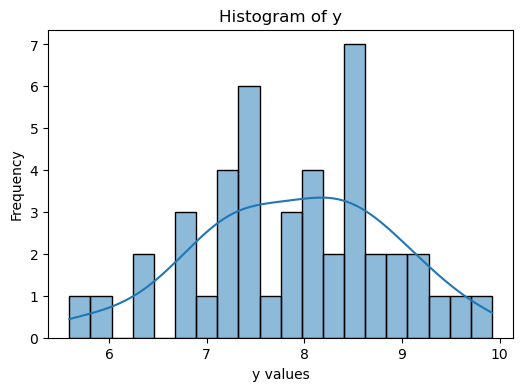

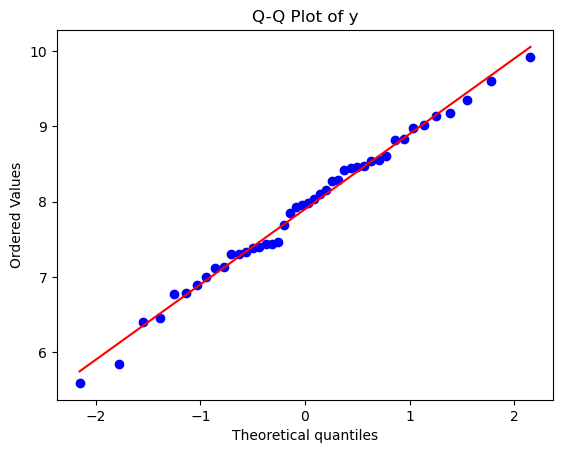

Skewness: -0.204


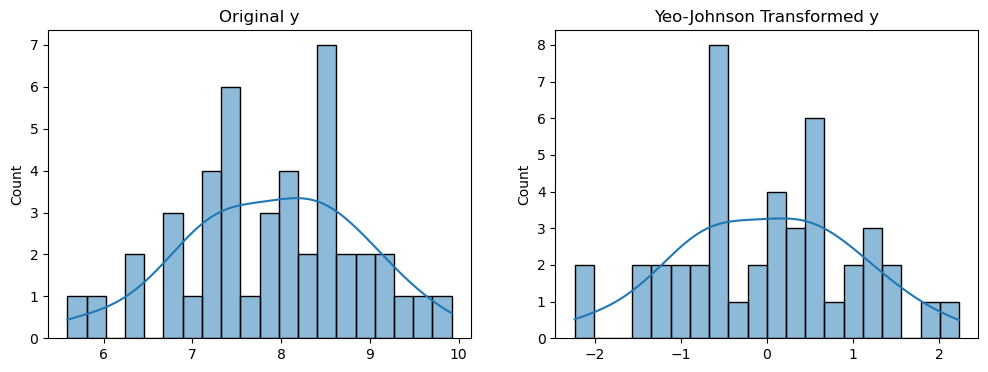

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True, bins=20)
plt.title("Histogram of y")
plt.xlabel("y values")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot of y")
plt.show()



skew_value = skew(y)
print(f"Skewness: {skew_value:.3f}")

## Before and after transformation

pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.reshape(-1, 1)).flatten()
plt.figure(figsize=(12, 4))

# Original y
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=20)
plt.title("Original y")

# Transformed y
plt.subplot(1, 2, 2)
sns.histplot(y_transformed, kde=True, bins=20)
plt.title("Yeo-Johnson Transformed y")

plt.show()


In [98]:

best_model, best_score, best_seed = None, -np.inf, None
rng = np.random.default_rng(42)
seeds = rng.integers(0, 1000, size=10)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=False,
    n_restarts_optimizer=10,
    random_state=0
)


for seed in seeds:
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=False,          # target normalization handled by TTR
        n_restarts_optimizer=10,
        random_state=seed
    )
    model = TransformedTargetRegressor(regressor=gpr, transformer=y_transformer)
    model.fit(X_scaled, y)

    score = model.regressor_.log_marginal_likelihood(model.regressor_.kernel_.theta)
    print(f"Seed={seed}, LogMargLik={score:.8f}")
    if score > best_score:
        best_score, best_model, best_seed = score, model, seed

print("\n Best model selected:")
print(f"   Seed: {best_seed}")
print(f"   Log Marginal Likelihood: {best_score:.8f}")
print(f"   Kernel: {best_model.regressor_.kernel_}")



Seed=89, LogMargLik=9.20544669
Seed=773, LogMargLik=9.20544669
Seed=654, LogMargLik=9.20544669
Seed=438, LogMargLik=9.20544669
Seed=433, LogMargLik=9.20544669
Seed=858, LogMargLik=9.20544671
Seed=85, LogMargLik=9.20544669
Seed=697, LogMargLik=9.20544669
Seed=201, LogMargLik=9.20544669
Seed=94, LogMargLik=9.20544669

 Best model selected:
   Seed: 858
   Log Marginal Likelihood: 9.20544671
   Kernel: 6.25**2 * Matern(length_scale=[14.2, 21.3, 12.8, 27.9, 71.7, 22.5, 17.6, 1e+05], nu=2.5) + WhiteKernel(noise_level=2.93e-05)


In [99]:
# ----------------------------
# In-sample fit quality (original space)
# ----------------------------
mu_tr, std_tr = best_model.regressor_.predict(X_scaled, return_std=True)  # transformed space
y_pred_orig = best_model.transformer_.inverse_transform(mu_tr.reshape(-1,1)).ravel()

rmse = np.sqrt(mean_squared_error(y, y_pred_orig))
r2 = r2_score(y, y_pred_orig)
print("\nModel Quality Summary:")
print(f"RMSE = {rmse:.6e}")
print(f"R²   = {r2:.6f}")


# ------------------------------------------------------------
# Current best observed (ORIGINAL space)
# ------------------------------------------------------------
best_obs_idx = int(np.argmax(y))                 # argmax on original y
x_best_obs = X[best_obs_idx]                     # ORIGINAL [0,1] coordinates
y_best_obs = float(y[best_obs_idx])              # ORIGINAL y value

# If you also want the transformed-space best (used by EI threshold),
# this is optional (EI already recomputes internally, but we can store it):
y_best_scaled = float(np.max(best_model.transformer_.transform(y.reshape(-1, 1))))

print(f"Best observed y (original) = {y_best_obs:.3e} at x = {np.round(x_best_obs,6).tolist()}")


Model Quality Summary:
RMSE = 7.359813e-04
R²   = 0.999999
Best observed y (original) = 9.923e+00 at x = [0.030705, 0.15659, 0.119116, 0.013055, 0.815887, 0.55761, 0.111981, 0.056969]


In [100]:
# ---------- Imports ----------
import os
import numpy as np
import pandas as pd

from scipy.stats import norm, qmc
# Assumes best_model is a TransformedTargetRegressor wrapping a GPR-like regressor
# that supports predict(..., return_std=True)

# ----------------------------
# Expected Improvement
# ----------------------------
def expected_improvement(X_candidate, best_model, X_scaler, y, xi=0.01):
    """
    EI computed in TRANSFORMED target space.
    Candidates X_candidate are in ORIGINAL [0,1] space.
    """
    Xc_scaled = X_scaler.transform(X_candidate)
    # mean/std in TRANSFORMED space (requires GPR-like regressor)
    mu, sigma = best_model.regressor_.predict(Xc_scaled, return_std=True)
    mu = mu.ravel()
    sigma = np.maximum(sigma.ravel(), 1e-12)

    # Best so far in TRANSFORMED space
    y_best_scaled = np.max(best_model.transformer_.transform(y.reshape(-1, 1)))

    Z = (mu - y_best_scaled - xi) / sigma
    ei = (mu - y_best_scaled - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma <= 1e-12] = 0.0
    return ei

# ============================================================
# 5️⃣ Candidate Search Space
# ============================================================
dim = X.shape[1]
grid_points = 100
xi_values = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

if dim == 2:
    # Generate 2D grid for visualization / dense search
    x1 = np.linspace(0, 1, grid_points)
    x2 = np.linspace(0, 1, grid_points)
    X1, X2 = np.meshgrid(x1, x2)
    X_candidates = np.c_[X1.ravel(), X2.ravel()]
else:
    # Latin Hypercube Sampling for 3D or higher
    n_samples = 10000
    sampler = qmc.LatinHypercube(d=dim)
    X_candidates = sampler.random(n=n_samples)  # already in [0,1]^d

# ============================================================
# 6️⃣ Compute EI and Suggest Next Point
# ============================================================
os.makedirs("ei_plots", exist_ok=True)
summary_rows = []

# Best observed in ORIGINAL space (for reporting)
best_idx_obs = int(np.argmax(y))
y_best_obs = float(y[best_idx_obs])
x_best_obs = X[best_idx_obs].copy()

# Best in TRANSFORMED space (for summary fields)
y_scaled_all = best_model.transformer_.transform(y.reshape(-1, 1)).ravel()
y_best_scaled = float(np.max(y_scaled_all))

# Optional placeholders if you track model selection externally
best_seed = globals().get("best_seed", None)
best_score = float(globals().get("best_score", np.nan))
SubmissionWk = globals().get("SubmissionWk", "NA")
FunctionName = globals().get("FunctionName", "F?")

for xi in xi_values:
    # ---- EI over candidate set (transformed y-space) ----
    ei_vals = expected_improvement(X_candidates, best_model, X_scaler, y, xi=xi)

    # ---- Next point (ORIGINAL [0,1] space) ----
    best_idx = int(np.argmax(ei_vals))
    x_next = X_candidates[best_idx]                 # original space
    x_next_scaled = X_scaler.transform([x_next])    # scaled for prediction
    x_next_6dp = np.round(x_next, 6).tolist()

    # ---- Predict at next point (transformed -> back to original) ----
    mu_next, sigma_next = best_model.regressor_.predict(x_next_scaled, return_std=True)
    mu_next = float(mu_next.ravel()[0])                        # transformed mean
    sigma_next = float(max(sigma_next.ravel()[0], 1e-12))      # transformed std

    # Mean in ORIGINAL space
    y_next_mean_orig = float(best_model.transformer_.inverse_transform([[mu_next]])[0, 0])
    # Approx 1σ in ORIGINAL via inverse-transform of (mu±σ)
    y_lo = best_model.transformer_.inverse_transform([[mu_next - sigma_next]])[0, 0]
    y_hi = best_model.transformer_.inverse_transform([[mu_next + sigma_next]])[0, 0]
    y_next_sigma_orig_approx = float(0.5 * (y_hi - y_lo))

    # ---- Console print ----
    print(
        f"ξ={xi:0.3f} → x_next (original) = {x_next_6dp}, "
        f"ŷ≈{y_next_mean_orig:.3e} ± {y_next_sigma_orig_approx:.3e} (original); "
        f"Best observed y={y_best_obs:.3e} at x={np.round(x_best_obs,6).tolist()}"
    )

    # ---- Row for summary CSV (store both original & scaled) ----
    summary_rows.append({
        "BestSeed": best_seed,
        "Xi": xi,
        "LogMarginalLikelihood": best_score,

        # Next query (original/scaled)
        "NextQuery_X_original": x_next.tolist(),
        "NextQuery_X_original_6dp": x_next_6dp,
        "NextQuery_X_scaled": X_scaler.transform([x_next]).ravel().tolist(),

        # Pred at next query (original + transformed)
        "PredMean_original": y_next_mean_orig,
        "PredSigma_original_approx": y_next_sigma_orig_approx,
        "PredMean_transformed": mu_next,
        "PredSigma_transformed": sigma_next,

        # Best observed (original + transformed best)
        "BestObserved_y_original": y_best_obs,
        "BestObserved_X_original": x_best_obs.tolist(),
        "BestObserved_y_transformed_best": y_best_scaled,

        # Kernel (if available on GPR)
        "Kernel": getattr(best_model.regressor_, "kernel_", None).__repr__() if hasattr(best_model.regressor_, "kernel_") else None,
    })

# Save summary
df_summary = pd.DataFrame(summary_rows).sort_values(by="LogMarginalLikelihood", ascending=False)
out_csv = f"ei_plots/EI_Model_Summary_{SubmissionWk}_{FunctionName}.csv"
df_summary.to_csv(out_csv, index=False)

print("\n✅ Summary saved:", out_csv)
print("EI plots saved in: ei_plots/")

# Report best observed y (both spaces)
y_best_original = float(best_model.transformer_.inverse_transform([[y_best_scaled]])[0, 0])
print("\nBest observed y (transformed):", y_best_scaled)
print("Best observed y (original):    ", y_best_original)

# Also show the top row from summary for convenience
if len(df_summary) > 0:
    print("\nTop row from summary:")
    print(df_summary.iloc[0])


ξ=0.001 → x_next (original) = [0.125485, 0.024944, 0.234349, 0.093835, 0.906125, 0.485175, 0.15787, 0.284763], ŷ≈9.951e+00 ± 4.966e-02 (original); Best observed y=9.923e+00 at x=[0.030705, 0.15659, 0.119116, 0.013055, 0.815887, 0.55761, 0.111981, 0.056969]
ξ=0.010 → x_next (original) = [0.125485, 0.024944, 0.234349, 0.093835, 0.906125, 0.485175, 0.15787, 0.284763], ŷ≈9.951e+00 ± 4.966e-02 (original); Best observed y=9.923e+00 at x=[0.030705, 0.15659, 0.119116, 0.013055, 0.815887, 0.55761, 0.111981, 0.056969]
ξ=0.050 → x_next (original) = [0.125485, 0.024944, 0.234349, 0.093835, 0.906125, 0.485175, 0.15787, 0.284763], ŷ≈9.951e+00 ± 4.966e-02 (original); Best observed y=9.923e+00 at x=[0.030705, 0.15659, 0.119116, 0.013055, 0.815887, 0.55761, 0.111981, 0.056969]
ξ=0.100 → x_next (original) = [0.125485, 0.024944, 0.234349, 0.093835, 0.906125, 0.485175, 0.15787, 0.284763], ŷ≈9.951e+00 ± 4.966e-02 (original); Best observed y=9.923e+00 at x=[0.030705, 0.15659, 0.119116, 0.013055, 0.815887, 0

Notes: 

> X_candidates = np.random.rand(10000, dim)

Instead of a grid, we use Monte Carlo sampling: draw 10,000 random points uniformly from [0,1]^d  <br>
Each column represents one compound or input variable.
This covers the search space broadly but efficiently — no explosion in the number of points.
You can increase 10,000 → 50,000 for finer resolution, at the cost of compute time.
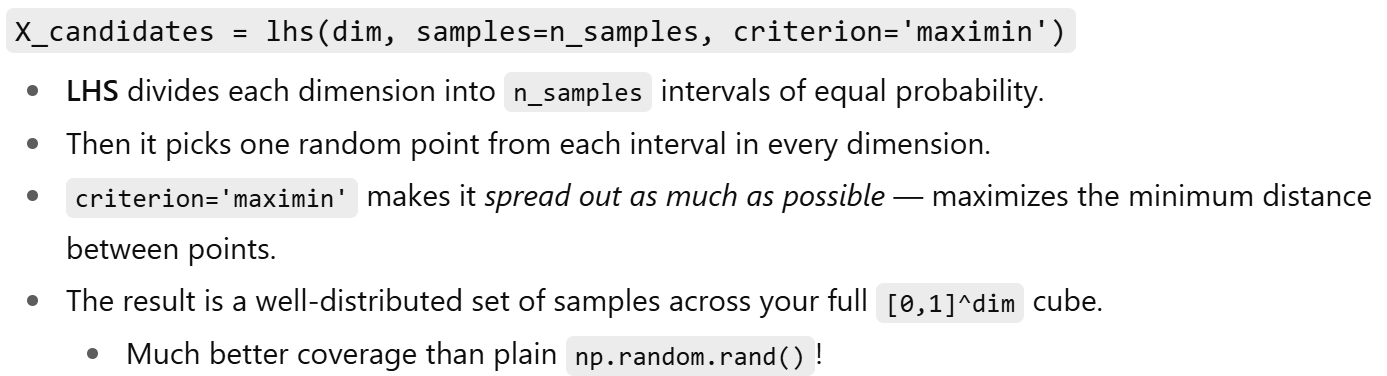
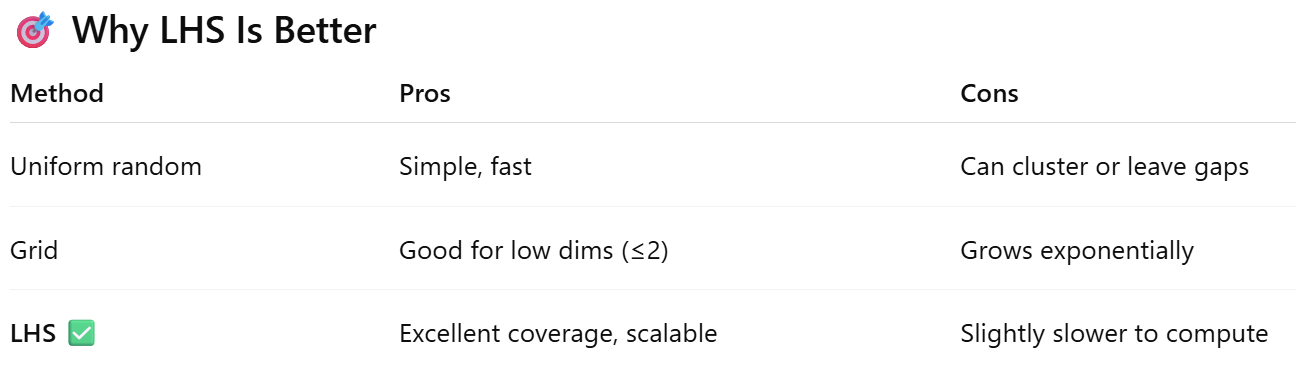

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, qmc
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ========== Data Setup (replace with your actual data) ==========
X = X
y = y

# ========== Preprocessing ==========
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_transformer = PowerTransformer(method="yeo-johnson", standardize=True)

# ========== Base SVR Model with transformed targets ==========
base_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model = TransformedTargetRegressor(regressor=base_svr, transformer=y_transformer)
model.fit(X_scaled, y)  # model.predict(...) returns y in ORIGINAL space

# ========== Bootstrap for Uncertainty Estimation ==========
n_bootstrap = 30
boot_predictions = np.zeros((n_bootstrap, X_scaled.shape[0]))

for i in range(n_bootstrap):
    X_resampled, y_resampled = resample(X_scaled, y, random_state=i)
    boot_model = TransformedTargetRegressor(
        regressor=SVR(kernel='rbf', C=1.0, epsilon=0.1),
        transformer=y_transformer
    )
    boot_model.fit(X_resampled, y_resampled)
    # NOTE: TransformedTargetRegressor.predict returns ORIGINAL y-space
    boot_predictions[i, :] = boot_model.predict(X_scaled)

# Compute mean and std for prediction uncertainty (on ORIGINAL y scale)
y_pred_mean = np.mean(boot_predictions, axis=0)
y_pred_std  = np.std(boot_predictions, axis=0)

# ========== Evaluate Model Quality ==========
mae  = mean_absolute_error(y, y_pred_mean)
rmse = np.sqrt(mean_squared_error(y, y_pred_mean))
r2   = r2_score(y, y_pred_mean)

print("Model Quality Summary:")
print(f"MAE  = {mae:.15f}")
print(f"RMSE = {rmse:.15f}")
print(f"R²   = {r2:.15f}")

# ========== Expected Improvement Acquisition Function ==========
def expected_improvement(X_candidate, model, X_scaler, y, boot_preds, xi=0.01):
    """
    EI is computed consistently in ORIGINAL y-space.
    sigma is approximated by the global bootstrap std (conservative fallback).
    """
    Xc_scaled = X_scaler.transform(X_candidate)
    mu = model.predict(Xc_scaled)  # ORIGINAL y-space
    # Conservative single sigma estimate (you could replace with a local model of uncertainty)
    sigma_global = np.std(boot_preds, axis=0).mean()
    sigma = np.maximum(sigma_global, 1e-9)
    y_best = np.max(y)  # best observed so far in ORIGINAL y-space

    Z = (mu - y_best - xi) / sigma
    ei = (mu - y_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei = np.maximum(ei, 0.0)
    return ei, mu

# ========== Candidate Sampling ==========
dim = X.shape[1]
if dim == 2:
    grid_points = 100
    x1 = np.linspace(0, 1, grid_points)
    x2 = np.linspace(0, 1, grid_points)
    X1, X2 = np.meshgrid(x1, x2)
    X_candidates = np.c_[X1.ravel(), X2.ravel()]
else:
    n_samples = 10000
    sampler = qmc.LatinHypercube(d=dim)
    X_candidates = sampler.random(n_samples)

# ========== Compute EI, Suggest Next Point, and Show Y-expected ==========
ei_values, mu_values = expected_improvement(X_candidates, model, X_scaler, y, boot_predictions, xi=0.01)
best_idx = np.argmax(ei_values)

x_next_scaled   = X_candidates[best_idx]
x_next_original = X_scaler.inverse_transform([x_next_scaled])[0]
x_next_original_6dp = np.round(x_next_original, 6)

# Y-expected (model's predicted y at the next query, ORIGINAL space)
y_expected_next = mu_values[best_idx]
ei_at_next      = ei_values[best_idx]

print("\nNext query point (scaled space):", x_next_scaled)
print("Next query point (original space):", x_next_original)
print("Next query point (rounded to 6 decimals):", x_next_original_6dp)
print(f"Y-expected at next query (model μ): {y_expected_next:.10f}")
print(f"EI at next query: {ei_at_next:.10f}")

# ========== Visualization (2D only) ==========
if dim == 2:
    ei_grid = ei_values.reshape(X1.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(X1, X2, ei_grid, levels=30, cmap='viridis')
    plt.colorbar(label='Expected Improvement (EI)')
    plt.scatter(X[:, 0], X[:, 1], c='white', edgecolor='black', s=70, label='Training Points')
    plt.scatter(x_next_original[0], x_next_original[1], c='red', s=120, marker='*', label='Next Query Point')
    plt.title(f'EI with SVR surrogate\nY-expected at next query = {y_expected_next:.6f}')
    plt.xlabel('Input Dim 1')
    plt.ylabel('Input Dim 2')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\n(Plot skipped — visualization only available for 2D inputs.)")


Model Quality Summary:
MAE  = 0.261114231153553
RMSE = 0.342193756491697
R²   = 0.874384945035242

Next query point (scaled space): [0.07109967 0.13089853 0.24207367 0.25130543 0.42472119 0.6801671
 0.47063005 0.61273587]
Next query point (original space): [0.54685441 0.50799842 0.57520023 0.48762329 0.60758573 0.65317234
 0.69197993 0.67766302]
Next query point (rounded to 6 decimals): [0.546854 0.507998 0.5752   0.487623 0.607586 0.653172 0.69198  0.677663]
Y-expected at next query (model μ): 9.9283218812
EI at next query: 0.0842629262

(Plot skipped — visualization only available for 2D inputs.)


--- Nural Network ---------------------

In [102]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import qmc
import json, os

# -------------------------
# d-dimensional helpers
# -------------------------
def soft_edge_penalty_nd(Xcand, margin=0.05):
    """
    Edge penalty in [0,1]^d: 0 in safe interior; 1 on boundary; linear within 'margin' of any face.
    Xcand: (N, d) in [0,1]^d
    """
    d_to_faces = np.concatenate([Xcand, 1.0 - Xcand], axis=1)   # (N, 2d)
    edge_dist = np.min(d_to_faces, axis=1)                      # nearest face distance
    return np.clip((margin - edge_dist) / margin, 0.0, 1.0)

def trust_region_bias_nd(Xcand, x_center, r_tr=0.25):
    """
    Soft trust-region boost: 1 at center, linearly down to 0 at radius r_tr, 0 beyond.
    """
    d = np.linalg.norm(Xcand - x_center[None, :], axis=1)
    return 1.0 - np.clip(d / r_tr, 0.0, 1.0)

def _fit_one_mlp(Xs, ys, hidden=(128, 64), alpha=3e-4, max_iter=1000, seed=0):
    mlp = MLPRegressor(
        hidden_layer_sizes=hidden, 
        activation="relu", 
        solver="adam",
        alpha=alpha, 
        learning_rate_init=5e-4,           # slightly smaller LR for stability
        max_iter=max_iter, 
        early_stopping=True,               # stop if val loss worsens
        n_iter_no_change=25,
        validation_fraction=0.2,
        random_state=seed
    )
    mlp.fit(Xs, ys)
    return mlp

# -------------------------
# main: next-point proposer for 3D–8D
# -------------------------
def nn_next_point_nd(
    X, y,
    hidden_grid=((128,64), (128,128)),   # slightly wider nets for higher d
    alpha_grid=(1e-4, 3e-4),
    n_models=9,                           # ensemble size
    bootstrap=True,
    n_candidates=60000,                   # Sobol candidates
    force_beats_best=False,               # set True if you want a strict threshold
    tol_rel=0.02, tol_abs=1e-6,
    use_penalties=True,
    w_tr=0.25, r_tr=0.25,                 # trust-region
    w_edge=0.5, margin=0.05,              # edge penalty
    random_state=123
):
    # ---- checks & prep
    X = np.asarray(X, float); y = np.asarray(y, float).ravel()
    n, d = X.shape
    assert 3 <= d <= 8, "This function is intended for 3D–8D."
    # incumbent
    i_best = int(np.argmax(y)); x_best = X[i_best].copy(); y_best = float(y[i_best])
    thr = (y_best + max(abs(y_best)*tol_rel, tol_abs)) if force_beats_best else -np.inf

    # ---- scalers
    sx = StandardScaler().fit(X);         Xs = sx.transform(X)
    sy = PowerTransformer(method="yeo-johnson", standardize=True).fit(y.reshape(-1,1))
    ys = sy.transform(y.reshape(-1,1)).ravel()

    # ---- candidates (Sobol in [0,1]^d)
    sob = qmc.Sobol(d=d, scramble=True, seed=random_state)
    Xcand = sob.random(n_candidates)
    Xcand_s = sx.transform(Xcand)

    rng = np.random.default_rng(random_state)

    best_pick = None      # (y_pred_mean, x, (hidden, alpha))
    best_over_thr = None

    # ---- hyperparam loops
    for hidden in hidden_grid:
        for alpha in alpha_grid:
            # fit ensemble
            ensemble = []
            for _ in range(n_models):
                if bootstrap:
                    idx = rng.integers(0, n, size=n)
                    Xb, yb = Xs[idx], ys[idx]
                else:
                    Xb, yb = Xs, ys
                seed = int(rng.integers(0, 10_000))
                ensemble.append(_fit_one_mlp(Xb, yb, hidden=hidden, alpha=alpha, seed=seed))

            # ---------- PREDICT (with sanitization) ----------
            preds_tr = np.stack([m.predict(Xcand_s) for m in ensemble], axis=0)   # (B, N)
            preds_tr = np.nan_to_num(preds_tr, nan=0.0, posinf=5.0, neginf=-5.0)  # NEW: guard bad values
            mu_tr = preds_tr.mean(axis=0)                                         # (N,)
            mu_tr = np.clip(mu_tr, -5.0, 5.0)                                     # NEW: keep inverse_transform safe
            mu = sy.inverse_transform(mu_tr.reshape(-1,1)).ravel()                # (N,)
            mu = np.nan_to_num(                                                   # NEW: guard original space too
                mu,
                nan=-np.inf,
                posinf=np.finfo(float).max,
                neginf=-np.finfo(float).max
            )

            # ---------- SELECTION SCORE (with robust masking) ----------
            if use_penalties:
                tr_b   = trust_region_bias_nd(Xcand, x_best, r_tr=r_tr)
                e_pen  = soft_edge_penalty_nd(Xcand, margin=margin)
                score  = mu + w_tr*tr_b - w_edge*e_pen
            else:
                score  = mu

            # Optional threshold (must beat current best)
            if force_beats_best:
                beat_mask = (mu > thr)
            else:
                beat_mask = np.ones_like(mu, dtype=bool)

            # NEW: mask non-finite or below-threshold scores
            finite_mask = np.isfinite(score) & beat_mask
            if not np.any(finite_mask):
                raise RuntimeError("All candidate scores are non-finite or below threshold; check scaling/model settings.")
            score = np.where(finite_mask, score, -np.inf)

            # pick best
            j = int(np.argmax(score))
            y_pred = float(mu[j])          # guaranteed finite due to mask
            x_next = Xcand[j]

            if (best_pick is None) or (y_pred > best_pick[0]):
                best_pick = (y_pred, x_next, (hidden, alpha))
            if y_pred > thr and ((best_over_thr is None) or (y_pred > best_over_thr[0])):
                best_over_thr = (y_pred, x_next, (hidden, alpha))

    chosen = best_over_thr if (force_beats_best and best_over_thr is not None) else best_pick
    y_pred, x_next, (hidden_sel, alpha_sel) = chosen

    # ---- diagnostics: refit chosen ensemble on full data
    ensemble = []
    for _ in range(n_models):
        seed = int(rng.integers(0, 10_000))
        ensemble.append(_fit_one_mlp(Xs, ys, hidden=hidden_sel, alpha=alpha_sel, seed=seed))
    y_hat_tr = np.stack([m.predict(Xs) for m in ensemble], axis=0).mean(axis=0)
    y_hat_tr = np.clip(np.nan_to_num(y_hat_tr, nan=0.0, posinf=5.0, neginf=-5.0), -5.0, 5.0)  # NEW: safe diag inversion
    y_hat = sy.inverse_transform(y_hat_tr.reshape(-1,1)).ravel()
    y_hat = np.nan_to_num(y_hat, nan=0.0, posinf=np.finfo(float).max, neginf=-np.finfo(float).max)

    rmse = float(np.sqrt(mean_squared_error(y, y_hat)))
    r2   = float(r2_score(y, y_hat))

    result = {
        "x_next": x_next.tolist(),
        "y_pred_next": float(y_pred),
        "beats_best": bool(y_pred > y_best),
        "best_obs": {"x": x_best.tolist(), "y": y_best},
        "nn_params": {
            "hidden": hidden_sel, "alpha": alpha_sel,
            "n_models": n_models, "bootstrap": bootstrap
        },
        "scalers": {"X": "StandardScaler", "y": "PowerTransformer(yeo-johnson)"},
        "rmse": rmse, "r2": r2
    }
    return result


# -------------------------

X = X   # (n, d) where 3 <= d <= 8
y = y
print(X)
print(y)

res = nn_next_point_nd(X, y, n_candidates=80000, force_beats_best=False)
print(json.dumps(res, indent=2))


[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


{
  "x_next": [
    0.04421714972704649,
    0.12097306735813618,
    0.046764046885073185,
    0.26980553939938545,
    0.959362018853426,
    0.2048941133543849,
    0.033367850817739964,
    0.6889021946117282
  ],
  "y_pred_next": 10.04959099142322,
  "beats_best": true,
  "best_obs": {
    "x": [
      0.030705,
      0.15659,
      0.119116,
      0.013055,
      0.815887,
      0.55761,
      0.111981,
      0.056969
    ],
    "y": 9.922815595
  },
  "nn_params": {
    "hidden": [
      128,
      64
    ],
    "alpha": 0.0003,
    "n_models": 9,
    "bootstrap": true
  },
  "scalers": {
    "X": "StandardScaler",
    "y": "PowerTransformer(yeo-johnson)"
  },
  "rmse": 0.18109054302014063,
  "r2": 0.9648205478373268
}
